In [1]:
#libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import pandas as pd
import sys
import math
import random
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn.metrics.cluster import contingency_matrix
from matplotlib import pyplot as plt

In [2]:
#load MNIST data

train_data = pd.read_csv('./mnist_train.csv', sep=',', header=None)
train_labels = train_data[0]
train_data = train_data.drop(0, axis=1)

test_data = pd.read_csv('./mnist_test.csv', sep=',', header=None)
test_labels = test_data[0]
test_data = test_data.drop(0, axis=1)

#separate data for generating graphs
graph_data = train_data.sample(n = 10000, random_state=100)
graph_labels = train_labels.sample(n = 10000, random_state=100)
train_data = train_data.drop(graph_data.index)
train_labels = train_labels.drop(graph_data.index)

#convert data to pytorch tensors
train_data = torch.FloatTensor(train_data.to_numpy())
train_labels = torch.LongTensor(train_labels.to_numpy())
test_data = torch.FloatTensor(test_data.to_numpy())
graph_data = torch.FloatTensor(graph_data.to_numpy())

In [3]:
input_size = 784
output_size = 10

In [4]:
#(50, 50) Vanilla FCN

class Vanilla_Net(nn.Module):
    def __init__(self):
        super(Vanilla_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.lrelu1 = nn.LeakyReLU(0.01) #default negative slope
        self.fc2 = nn.Linear(50, 50)
        self.lrelu2 = nn.LeakyReLU(0.01) #default negative slope
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.lrelu1(x)
        x = self.fc2(x)
        x = self.lrelu2(x)
        x = self.fc3(x)
        return F.log_softmax(x)

In [5]:
def SGD(net, optimizer, loss, epochs, train_data, train_labels, batch_size):
    for i in range(epochs):
        for j in range(0, train_data.shape[0], batch_size):
            data_minibatch = Variable(train_data[j : j+batch_size])
            label_minibatch = Variable(train_labels[j: j+batch_size])
            optimizer.zero_grad()
            net_out = net(data_minibatch)
            net_loss = loss(net_out, label_minibatch)
            net_loss.backward()
            optimizer.step()

In [6]:
def test_accuracy(net, test_data, test_labels):
    net_out = net(test_data)
    test_out = torch.max(net_out.data, 1)[1].numpy()
    return np.count_nonzero(test_out==test_labels) / len(test_labels)

In [417]:
#determine optimal # of epochs for SGD

epochs = 5
batch_size = 50 #typical value
learning_rate = 0.0001 
mmt = 0.9 #typical value
cur_accuracy = 0
prev_accuracy = 0
while True:
    prev_accuracy = cur_accuracy
    my_net = Vanilla_Net()
    optimizer = torch.optim.SGD(my_net.parameters(), lr=learning_rate, momentum=mmt)
    loss = nn.CrossEntropyLoss()
    SGD(my_net, optimizer, loss, epochs, train_data, train_labels, batch_size)
    cur_accuracy = test_accuracy(my_net, test_data, test_labels)
    print(cur_accuracy)
    if (cur_accuracy <= prev_accuracy-0.005):
        break
    epochs += 1
epochs -= 1
print(epochs)

C:\Users\ethan\AppData\Local\Temp\ipykernel_12060\2732752644.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


0.9487
0.9479
0.9511
0.9519


KeyboardInterrupt: 

After running the above code a few times, it seems like the network typically achieves high accuracy after around 20 epochs. 

In [7]:
# join train and test data

train_test_data = torch.cat((train_data, test_data))
train_test_labels = torch.cat((train_labels, torch.LongTensor(test_labels.to_numpy())))

In [8]:
# train vanilla network with train+test data

def train_vanilla():
    vanilla_net = Vanilla_Net()
    optimizer = torch.optim.SGD(vanilla_net.parameters(), lr=0.0001, momentum=0.9)
    loss = nn.CrossEntropyLoss()
    SGD(vanilla_net, optimizer, loss, epochs=20, train_data=train_test_data, train_labels=train_test_labels, batch_size=50)
    return vanilla_net

In [9]:
# (50, 50) FCN trained with batch norm

class BN_Net(nn.Module):
    def __init__(self):
        super(BN_Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.bn1 = nn.BatchNorm1d(50)
        self.lrelu1 = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(50, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.lrelu2 = nn.LeakyReLU(0.01)
        self.fc3 = nn.Linear(50, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.lrelu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.lrelu2(x)
        x = self.fc3(x)
        return F.log_softmax(x)

In [78]:
#determine optimal # of epochs for batch_norm_net

epochs = 20
batch_size = 50 #typical value
learning_rate = 0.0001 
mmt = 0.9 #typical value
cur_accuracy = 0
prev_accuracy = 0
while True:
    prev_accuracy = cur_accuracy
    my_net = BN_Net()
    optimizer = torch.optim.SGD(my_net.parameters(), lr=learning_rate, momentum=mmt)
    loss = nn.CrossEntropyLoss()
    SGD(my_net, optimizer, loss, epochs, train_data, train_labels, batch_size)
    cur_accuracy = test_accuracy(my_net, test_data, test_labels)
    print(cur_accuracy)
    if (cur_accuracy <= prev_accuracy-0.01):
        break
    epochs += 1
epochs -= 1
print(epochs)

C:\Users\ethan\AppData\Local\Temp\ipykernel_24688\1325394341.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


KeyboardInterrupt: 

The batch norm network achieves high accuracy after 20 epochs. 

In [10]:
# train batch norm network

def train_batch_norm():
    batch_norm_net = BN_Net()
    optimizer = torch.optim.SGD(batch_norm_net.parameters(), lr=0.0001, momentum=0.9)
    loss = nn.CrossEntropyLoss()
    SGD(batch_norm_net, optimizer, loss, epochs=20, train_data=train_test_data, train_labels=train_test_labels, batch_size=50)
    return batch_norm_net

In [11]:
# train n networks for each strategy

n_networks = 20
vanilla_nets = []
batch_norm_nets = []

for i in range(n_networks):
    vanilla_nets.append(train_vanilla())
    batch_norm_nets.append(train_batch_norm())

C:\Users\ethan\AppData\Local\Temp\ipykernel_5308\805662490.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\ethan\AppData\Local\Temp\ipykernel_5308\1325394341.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [12]:
#extract neuron outputs

def neuron_values(net, data):
    activations = []
    def get_activation():
        def hook(model, input, output):
            activations.append(output.detach())
        return hook
    
    net.lrelu1.register_forward_hook(get_activation())
    net.lrelu2.register_forward_hook(get_activation())
    net.eval()
    net(data)
    
    activations[0] = activations[0].numpy()
    activations[1] = activations[1].numpy()
    neurons = np.concatenate((activations[0].T, activations[1].T))
    return neurons

In [13]:
vanilla_neurons = []
batch_norm_neurons = []

for i in range(n_networks):
    vanilla_neurons.append(neuron_values(vanilla_nets[i], graph_data))
    batch_norm_neurons.append(neuron_values(batch_norm_nets[i], graph_data))

C:\Users\ethan\AppData\Local\Temp\ipykernel_5308\805662490.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\ethan\AppData\Local\Temp\ipykernel_5308\1325394341.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [14]:
def correlation_graph(neurons):
    adj_matrix = abs(np.corrcoef(neurons))
    np.fill_diagonal(adj_matrix, 0)
    return adj_matrix

In [15]:
#split neuron data for one network into n subsets to construct n graphs

n_subsets = 100

vanilla_subsets = np.array_split(vanilla_neurons[0], n_subsets, 1)
batch_norm_subsets = np.array_split(batch_norm_neurons[0], n_subsets, 1)

In [86]:
#construct network graphs for subsets

subset_network_graphs = []

for i in range(n_subsets):
    subset_network_graphs.append(correlation_graph(vanilla_subsets[i]))
    subset_network_graphs.append(correlation_graph(batch_norm_subsets[i]))

In [16]:
#construct network graphs for distinct networks

network_graphs = []

for i in range(n_networks):
    network_graphs.append(correlation_graph(vanilla_neurons[i]))
    network_graphs.append(correlation_graph(batch_norm_neurons[i]))

In [17]:
#topological clustering framework

class TopClustering:
    """Topological clustering.
    
    Attributes:
        n_clusters: 
          The number of clusters.
        top_relative_weight:
          Relative weight between the geometric and topological terms.
          A floating point number between 0 and 1.
        max_iter_alt:
          Maximum number of iterations for the topological clustering.
        max_iter_interp:
          Maximum number of iterations for the topological interpolation.
        learning_rate:
          Learning rate for the topological interpolation.
        
    Reference:
        Songdechakraiwut, Tananun, Bryan M. Krause, Matthew I. Banks, Kirill V. Nourski, and Barry D. Van Veen. 
        "Fast topological clustering with Wasserstein distance." 
        International Conference on Learning Representations (ICLR). 2022.
    """

    def __init__(self, n_clusters, top_relative_weight, max_iter_alt,
                 max_iter_interp, learning_rate):
        self.n_clusters = n_clusters
        self.top_relative_weight = top_relative_weight
        self.max_iter_alt = max_iter_alt
        self.max_iter_interp = max_iter_interp
        self.learning_rate = learning_rate

    def fit_predict(self, data):
        """Computes topological clustering and predicts cluster index for each sample.
        
            Args:
                data:
                  Training instances to cluster.
                  
            Returns:
                Cluster index each sample belongs to.
        """
        data = np.asarray(data)
        n_node = data.shape[1]
        n_edges = math.factorial(n_node) // math.factorial(2) // math.factorial(
            n_node - 2)  # n_edges = (n_node choose 2)
        n_births = n_node - 1
        self.weight_array = np.append(
            np.repeat(1 - self.top_relative_weight, n_edges),
            np.repeat(self.top_relative_weight, n_edges))

        # Networks represented as vectors concatenating geometric and topological info
        X = []
        for adj in data:
            X.append(self._vectorize_geo_top_info(adj))
        X = np.asarray(X)

        # Random initial condition
        self.centroids = X[random.sample(range(X.shape[0]), self.n_clusters)]

        # Assign the nearest centroid index to each data point
        assigned_centroids = self._get_nearest_centroid(
            X[:, None, :], self.centroids[None, :, :])
        prev_assigned_centroids = assigned_centroids

        for it in range(self.max_iter_alt):
            for cluster in range(self.n_clusters):
                # Previous iteration centroid
                prev_centroid = np.zeros((n_node, n_node))
                prev_centroid[np.triu_indices(
                    prev_centroid.shape[0],
                    k=1)] = self.centroids[cluster][:n_edges]

                # Determine data points belonging to each cluster
                cluster_members = X[assigned_centroids == cluster]

                # Compute the sample mean and top. centroid of the cluster
                cc = cluster_members.mean(axis=0)
                sample_mean = np.zeros((n_node, n_node))
                sample_mean[np.triu_indices(sample_mean.shape[0],
                                            k=1)] = cc[:n_edges]
                top_centroid = cc[n_edges:]
                top_centroid_birth_set = top_centroid[:n_births]
                top_centroid_death_set = top_centroid[n_births:]

                # Update the centroid
                try:
                    cluster_centroid = self._top_interpolation(
                        prev_centroid, sample_mean, top_centroid_birth_set,
                        top_centroid_death_set)
                    self.centroids[cluster] = self._vectorize_geo_top_info(
                        cluster_centroid)
                except:
                    print(
                        'Error: Possibly due to the learning rate is not within appropriate range.'
                    )
                    sys.exit(1)

            # Update the cluster membership
            assigned_centroids = self._get_nearest_centroid(
                X[:, None, :], self.centroids[None, :, :])

            # Compute and print loss as it is progressively decreasing
            loss = self._compute_top_dist(
                X, self.centroids[assigned_centroids]).sum() / len(X)
            #print('Iteration: %d -> Loss: %f' % (it, loss))

            if (prev_assigned_centroids == assigned_centroids).all():
                break
            else:
                prev_assigned_centroids = assigned_centroids
        return assigned_centroids

    def _vectorize_geo_top_info(self, adj):
        birth_set, death_set = self._compute_birth_death_sets(
            adj)  # topological info
        vec = adj[np.triu_indices(adj.shape[0], k=1)]  # geometric info
        return np.concatenate((vec, birth_set, death_set), axis=0)

    def _compute_birth_death_sets(self, adj):
        """Computes birth and death sets of a network."""
        mst, nonmst = self._bd_demomposition(adj)
        birth_ind = np.nonzero(mst)
        death_ind = np.nonzero(nonmst)
        return np.sort(mst[birth_ind]), np.sort(nonmst[death_ind])

    def _bd_demomposition(self, adj):
        """Birth-death decomposition."""
        eps = np.nextafter(0, 1)
        adj[adj == 0] = eps
        adj = np.triu(adj, k=1)
        Xcsr = csr_matrix(-adj)
        Tcsr = minimum_spanning_tree(Xcsr)
        mst = -Tcsr.toarray()  # reverse the negative sign
        nonmst = adj - mst
        birth_ind = np.nonzero(mst)
        return mst, nonmst

    def _get_nearest_centroid(self, X, centroids):
        """Determines cluster membership of data points."""
        dist = self._compute_top_dist(X, centroids)
        nearest_centroid_index = np.argmin(dist, axis=1)
        return nearest_centroid_index

    def _compute_top_dist(self, X, centroid):
        """Computes the pairwise top. distances between networks and centroids."""
        return np.dot((X - centroid)**2, self.weight_array)

    def _top_interpolation(self, init_centroid, sample_mean,
                           top_centroid_birth_set, top_centroid_death_set):
        """Topological interpolation."""
        curr = init_centroid
        for _ in range(self.max_iter_interp):
            # Geometric term gradient
            geo_gradient = 2 * (curr - sample_mean)

            # Topological term gradient
            sorted_birth_ind, sorted_death_ind = self._compute_optimal_matching(
                curr)
            top_gradient = np.zeros_like(curr)
            top_gradient[sorted_birth_ind] = top_centroid_birth_set
            top_gradient[sorted_death_ind] = top_centroid_death_set
            top_gradient = 2 * (curr - top_gradient)

            # Gradient update
            curr -= self.learning_rate * (
                (1 - self.top_relative_weight) * geo_gradient +
                self.top_relative_weight * top_gradient)
        return curr

    def _compute_optimal_matching(self, adj):
        mst, nonmst = self._bd_demomposition(adj)
        birth_ind = np.nonzero(mst)
        death_ind = np.nonzero(nonmst)
        sorted_temp_ind = np.argsort(mst[birth_ind])
        sorted_birth_ind = tuple(np.array(birth_ind)[:, sorted_temp_ind])
        sorted_temp_ind = np.argsort(nonmst[death_ind])
        sorted_death_ind = tuple(np.array(death_ind)[:, sorted_temp_ind])
        return sorted_birth_ind, sorted_death_ind


In [18]:
def purity_score(labels_true, labels_pred):
    mtx = contingency_matrix(labels_true, labels_pred)
    return np.sum(np.amax(mtx, axis=0)) / np.sum(mtx)

In [19]:
def purity_stats(iterations, top_clust, graphs, labels_true):
    scores = np.zeros(iterations)
    for i in range(iterations):
        labels_pred = top_clust.fit_predict(graphs)
        scores[i] = purity_score(labels_pred, labels_true)
    
    return np.mean(scores), np.std(scores)

In [20]:
n_clusters = 2
max_iter_alt = 300
max_iter_interp = 300
learning_rate = 0.05

iterations = 50
labels_true = np.empty(2*n_networks)
labels_true[::2] = 0
labels_true[1::2] = 1

In [21]:
#clustering network graphs and computing purity w/ varying topological weights

top_weights = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]
purity = []

for w in top_weights:
    top_clust = TopClustering(n_clusters, w, max_iter_alt,
                                    max_iter_interp,
                                    learning_rate)
    purity.append(np.asarray(purity_stats(iterations, top_clust, network_graphs, labels_true)))


[0.9365 0.907  0.925  0.9025 0.968  0.9675 0.9785 0.9875 0.996  1.
 1.    ]
[0.06693467 0.10050373 0.08529361 0.12229575 0.07842831 0.06675515
 0.07858276 0.05226136 0.02467793 0.         0.        ]


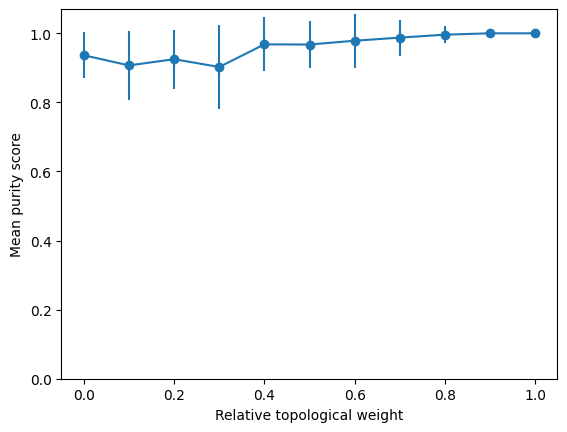

In [23]:
purity = np.asarray(purity)
purity_means = purity[:, 0]
purity_stds = purity[:, 1]

plt.scatter(top_weights, purity_means)
plt.xlabel("Relative topological weight")
plt.ylabel("Mean purity score")
plt.ylim([0, 1.07])
plt.errorbar(top_weights, purity_means, purity_stds)

print(purity_means)
print(purity_stds)